# Adding Genre Data via Spotipy and Spotify API Access
This will allow me to do more in-depth analysis on my data.

In [1]:
import os
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Load variables from .env file
load_dotenv()

client_id = os.getenv('SPOTIPY_CLIENT_ID')
client_secret = os.getenv('SPOTIPY_CLIENT_SECRET')

auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [2]:
import pandas as pd
import os
import json

# Load your actual Spotify data (same as in initial exploration)
data_path = '../data/Spotify Extended Streaming History'
dfs = []

for file in os.listdir(data_path):
    if file.endswith('.json') and file != 'artist_genre_map.json':
        dfs.append(pd.read_json(os.path.join(data_path, file)))

df = pd.concat(dfs, ignore_index=True)

# Clean up the data
df['ts'] = pd.to_datetime(df['ts'])
df['year'] = df['ts'].dt.year
df['month'] = df['ts'].dt.month
df['hour'] = df['ts'].dt.hour

df.rename(columns={'master_metadata_album_artist_name': 'artist', 'master_metadata_track_name': 'track'}, inplace=True)

# Get all unique artists from your listening history
unique_artists = df['artist'].dropna().unique()
print(f"Found {len(unique_artists)} unique artists in your listening history")

genre_map_path = os.path.join(data_path, 'artist_genre_map.json')

if os.path.exists(genre_map_path):
    print("Loading artist_genre_map from cache...")
    with open(genre_map_path, 'r', encoding='utf-8') as f:
        if os.stat(genre_map_path).st_size == 0:  # Check if the file is empty
            print("The artist_genre_map.json file is empty. Initializing an empty dictionary.")
            artist_genre_map = {}
        else:
            artist_genre_map = json.load(f)
else:
    print("Generating artist_genre_map from Spotify API...")
    artist_genre_map = {}
    processed = 0

    for artist in unique_artists:
        try:
            results = sp.search(q=f'artist:{artist}', type='artist', limit=1)
            items = results['artists']['items']
            if items:
                genres = items[0]['genres']
                artist_genre_map[artist] = genres
            else:
                artist_genre_map[artist] = []

            processed += 1
            if processed % 50 == 0:
                print(f"Processed {processed}/{len(unique_artists)} artists")

        except Exception as e:
            print(f"Error with {artist}: {e}")
            artist_genre_map[artist] = []

    with open(genre_map_path, 'w', encoding='utf-8') as f:
        json.dump(artist_genre_map, f, indent=2)
    print("Saved artist_genre_map to JSON.")

Found 5251 unique artists in your listening history
Loading artist_genre_map from cache...


## Assign Genres and Clean Data
Assign genres to each artist and clean the dataset by filtering out unknown genres.

In [3]:
# Assign genres and clean
df['genre'] = df['artist'].map(lambda a: artist_genre_map.get(a, ['Unknown'])[0] if artist_genre_map.get(a) else 'Unknown')

# Filter out unknown genres
before = len(df)
df = df[df['genre'] != 'Unknown']
after = len(df)
print(f"Dropped {before - after:,} plays with unknown genres")

# Summary stats
total_plays = len(df)
genre_counts = df['genre'].value_counts()

print(f"\nTotal plays: {total_plays:,}")
print(f"Unique genres: {df['genre'].nunique()}")
print(f"\nTop 10 genres by play count:\n{genre_counts.head(10)}")

# Sample of artists with genres
print("\nSample of artists with their genres:")
print(df[['artist', 'genre']].drop_duplicates().head(20))

Dropped 120,702 plays with unknown genres

Total plays: 118,263
Unique genres: 378

Top 10 genres by play count:
genre
rap                     41052
rage rap                14310
melodic rap             13662
hip hop                  6361
r&b                      2723
chicago drill            1980
metal                    1800
alternative hip hop      1796
southern hip hop         1765
experimental hip hop     1678
Name: count, dtype: int64

Sample of artists with their genres:
                                             artist              genre
0                                     Drowning Pool           nu metal
1                                       DevilDriver       groove metal
2                                         Disturbed              metal
3                                         Metallica              metal
4                          Rage Against The Machine          rap metal
5                                       Linkin Park           nu metal
8                   

## Artist Genre Map Created
I now have all the artists without an unknown genre recorded, and can now do a more in-depth analysis.

## Genre Listening by Hour of Day
This heatmap will allow me to view during what hours of the days of the week my music listening peaked.

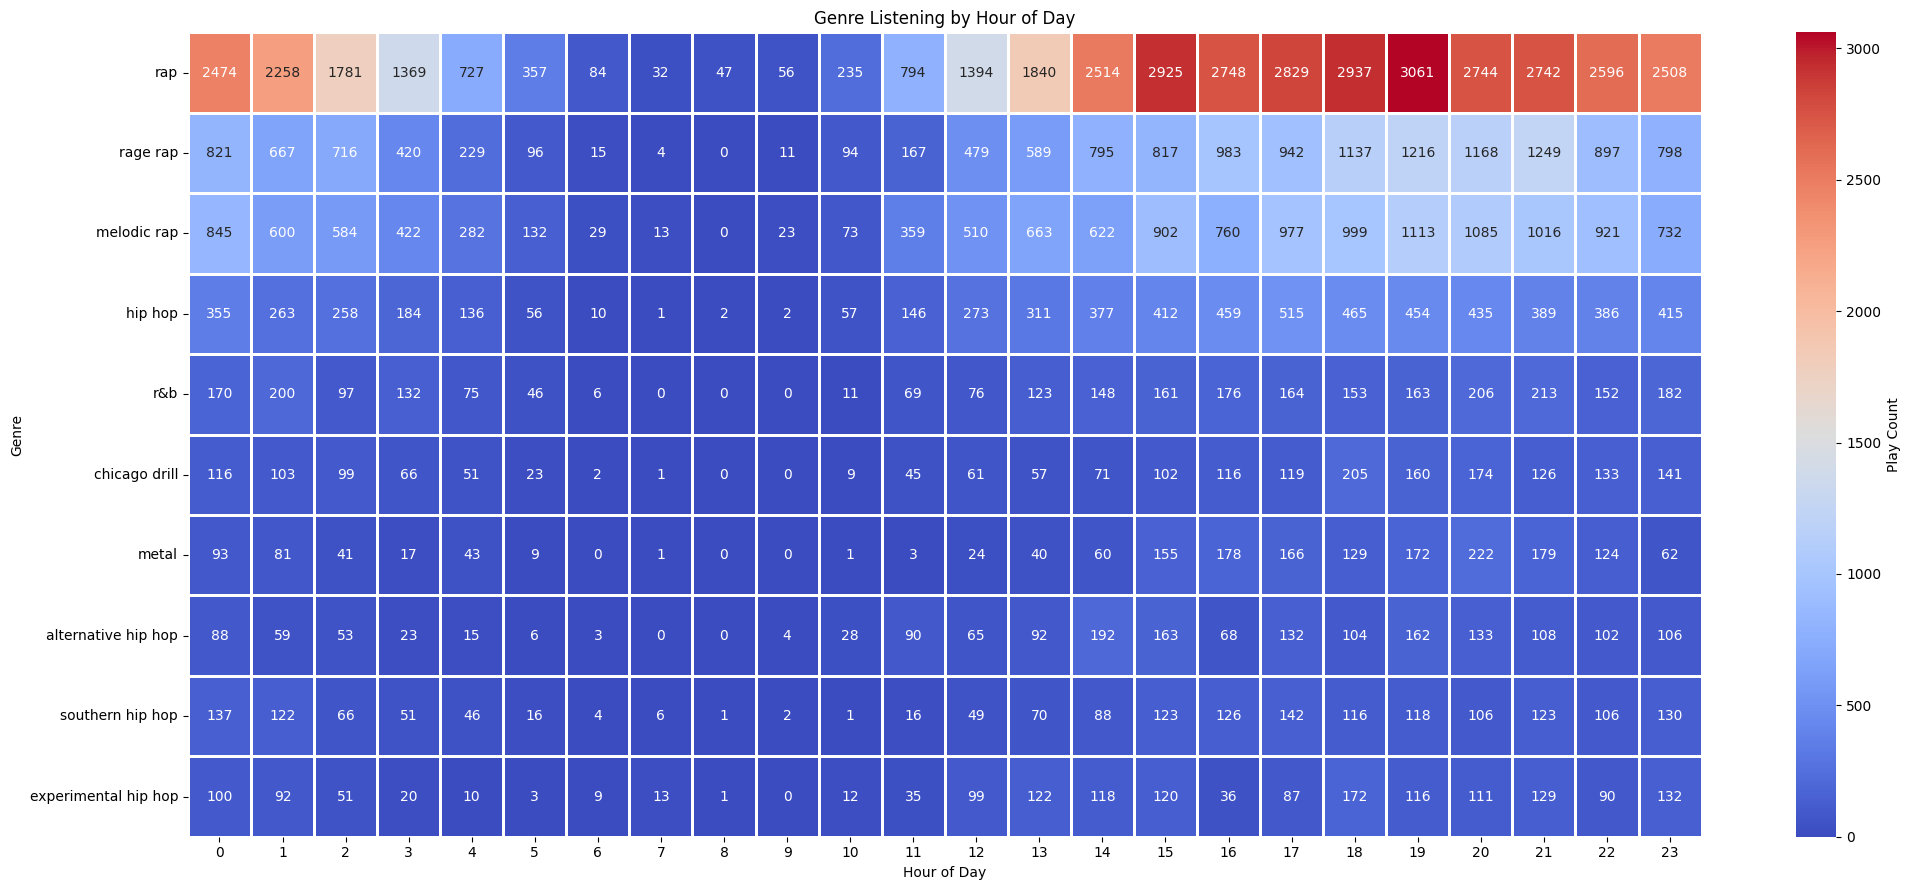

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by genre and hour
genre_hour_counts = df.groupby(['genre', 'hour']).size().reset_index(name='count')

# Pivot for heatmap shape (rows = genre, cols = hour)
genre_hour_pivot = genre_hour_counts.pivot(index='genre', columns='hour', values='count').fillna(0)

# Get your top 20 most listened-to genres
top_genres = df['genre'].value_counts().head(10).index
genre_hour_top = genre_hour_pivot.loc[top_genres]
plt.figure(figsize=(21, 9))
sns.heatmap(genre_hour_top, cmap="coolwarm", linewidths=0.75, annot=True, fmt=".0f", cbar_kws={'label': 'Play Count'})

plt.title("Genre Listening by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


- Rap dominates my genre preference, and is mostly being played later in the afternoon, around 12:00 PM to 2:00 AM
- I tend not to listen to much in the morning and it typically picks up around 10:00 AM
- More laid-back genres, like R&B tend to peak in the late hours of the night

## Monthly Genre Listening Trends
This line chart will show me what month correletes to the genre I was listening to

In [5]:
# Group by genre and month
genre_month_counts = df.groupby(['genre', 'month']).size().reset_index(name='count')

# Pivot for plotting
genre_month_pivot = genre_month_counts.pivot(index='genre', columns='month', values='count').fillna(0)

# Focus on top genres
top_genres = df['genre'].value_counts().head(8).index
genre_month_top = genre_month_pivot.loc[top_genres]


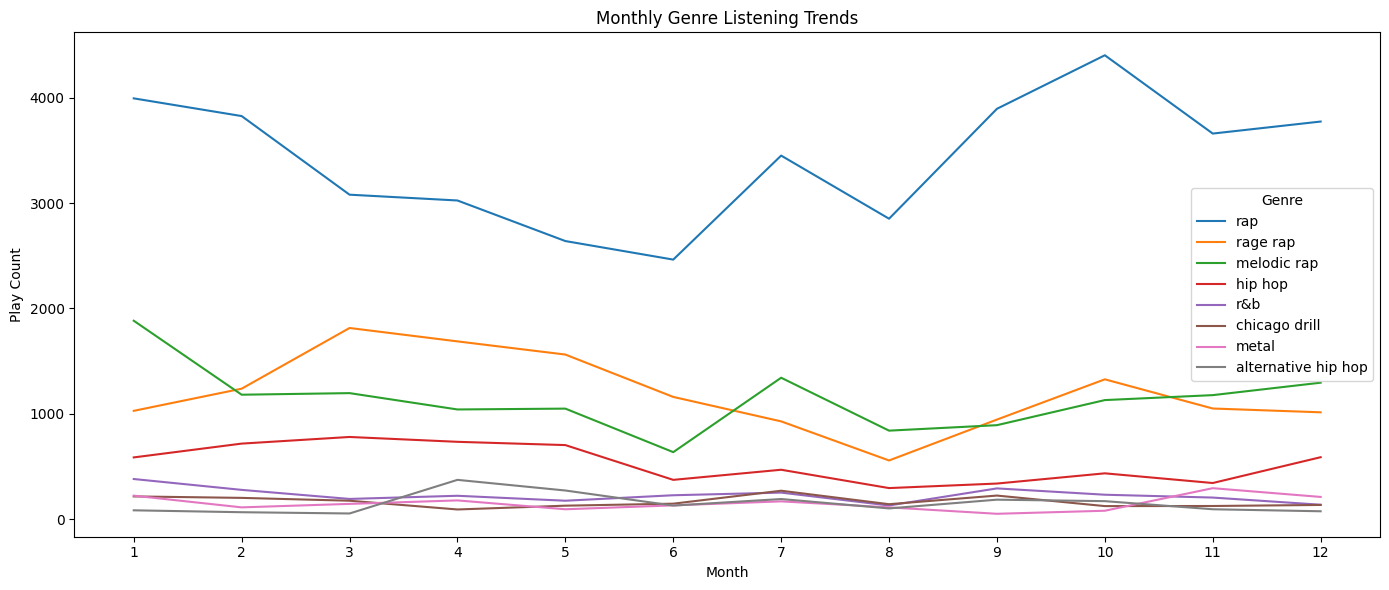

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

for genre in genre_month_top.index:
    plt.plot(genre_month_top.columns, genre_month_top.loc[genre], label=genre)

plt.title("Monthly Genre Listening Trends")
plt.xlabel("Month")
plt.ylabel("Play Count")
plt.xticks(range(1, 13))
plt.legend(title="Genre")
plt.tight_layout()
plt.show()


## Genre Listening by Season
My clustered bar chart will display my genre listening habits per season

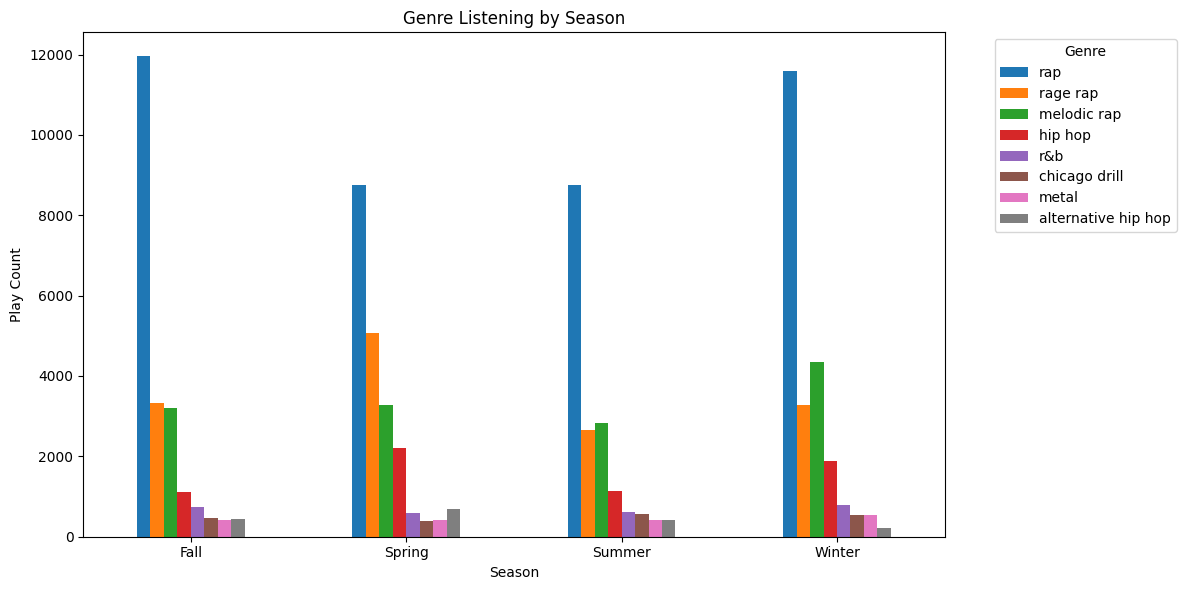

In [7]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)

genre_season_counts = df.groupby(['genre', 'season']).size().reset_index(name='count')
genre_season_pivot = genre_season_counts.pivot(index='genre', columns='season', values='count').fillna(0)

genre_season_top = genre_season_pivot.loc[top_genres]

genre_season_top.T.plot(kind='bar', figsize=(12, 6))

plt.title("Genre Listening by Season")
plt.xlabel("Season")
plt.ylabel("Play Count")
plt.xticks(rotation=0)
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Genre Listening by Month/Season
- These two graphs gave me some insight, noteably that I listen to a lot of rap
- However some other trends I noticed were that in the summer months, most genres tend to drop, which could be from being on my phone and spotify less
- Winter tends to be the busiest time for a more laid-back type of genre to spike, like R&B and melodic rap
- Spring having the highest amount of rage rap to me tells me I listen to a lot more up beat and aggressive music around the time of studying for finals

## Top Genre Transitions
This Sankey diagram will show me the most common transtions between genres I made.

In [8]:
import plotly.graph_objects as go

# Sort by timestamp
df_sorted = df.sort_values('ts').reset_index(drop=True)

# Get the next genre
df_sorted['next_genre'] = df_sorted['genre'].shift(-1)

# Filter out invalid transitions and same-genre transitions
genre_transitions = df_sorted[['genre', 'next_genre']].dropna()
genre_transitions = genre_transitions[genre_transitions['genre'] != genre_transitions['next_genre']]

# Count transitions
transition_counts = genre_transitions.groupby(['genre', 'next_genre']).size().reset_index(name='count')

# Keep only top 15 transitions (adjust if you want more)
top_transitions = transition_counts.sort_values('count', ascending=False).head(15)

# Get unique labels in order of appearance
labels = list(pd.unique(top_transitions[['genre', 'next_genre']].values.ravel()))

# Map genre to index
label_to_index = {label: i for i, label in enumerate(labels)}

# Build source, target, and value lists
source = top_transitions['genre'].map(label_to_index)
target = top_transitions['next_genre'].map(label_to_index)
value = top_transitions['count']

# Define color by genre group
color_map = {
    'rap': 'red',
    'melodic rap': 'orange',
    'rage rap': 'pink',
    'hip hop': 'blue',
    'r&b': 'purple',
    'metal': 'gray',
    # add more if needed...
}
node_colors = [color_map.get(label, 'lightgray') for label in labels]

# Uncomment below if using custom colors:
# node_color_arg = dict(color=node_colors)
node_color_arg = {}

# Create Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=.25),
        label=labels,
        **node_color_arg
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        hovertemplate='From %{source.label} → %{target.label}: %{value} transitions<extra></extra>'
    )
)])

fig.update_layout(title_text="Top Genre Transitions (Back-to-Back Plays)", font_size=10)
fig.show()


- Rap is the central hub for most of my music transtions, I either start or end listening to this genre the most
- Melodic Rap is typically followed up from rap, while rap will often be followed by mainstream rap, telling me I usually go from something a lot heavier and louder into something softer
- Miscellaneous genres like R&B and cloud rap are often folllowed by rap, but rarely are a hub for many transitions

## Genre Listening Trends Over Years
This stacked area chart will provide insight into how my genres varied and developed over time.

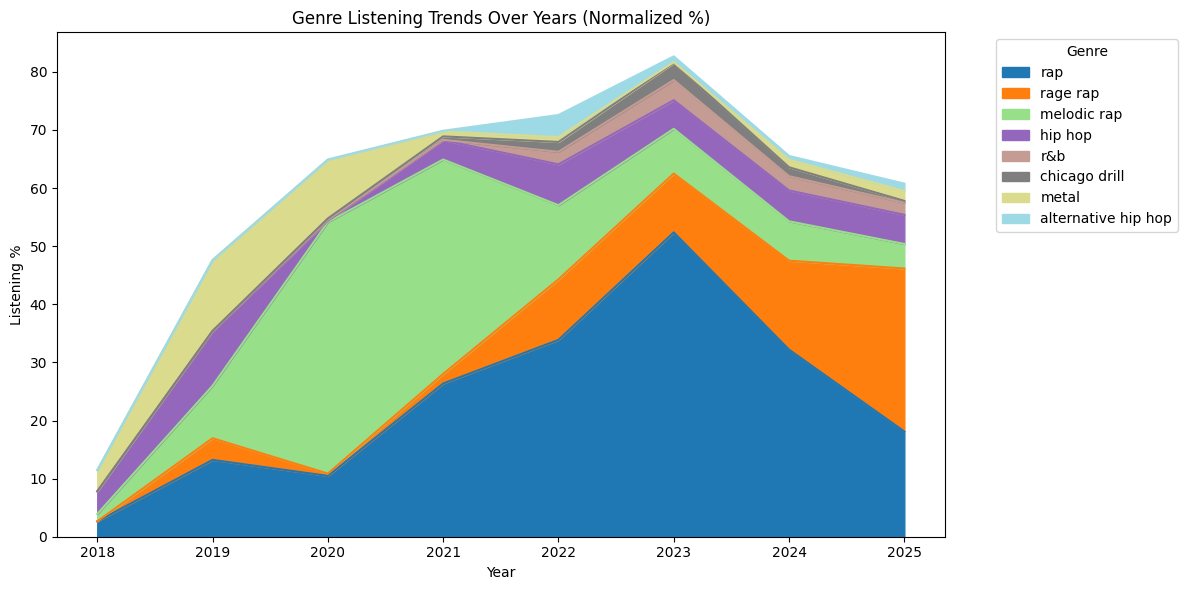

In [9]:
genre_year_counts = df.groupby(['year', 'genre']).size().reset_index(name='count')
genre_year_pivot = genre_year_counts.pivot(index='year', columns='genre', values='count').fillna(0)
genre_year_pct = genre_year_pivot.div(genre_year_pivot.sum(axis=1), axis=0) * 100
top_genres = df['genre'].value_counts().head(8).index
genre_year_pct_top = genre_year_pct[top_genres]

genre_year_pct_top.plot(kind='area', figsize=(12, 6), colormap='tab20')

plt.title("Genre Listening Trends Over Years (Normalized %)")
plt.xlabel("Year")
plt.ylabel("Listening %")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


- Rap has always been a very dominant genre for me, however metal was a strong force in the beginning of my listening history and is slowly increasing in 2025
- Melodic rap was a strong genre in my early rap phases with the surge of rappers like Juice WRLD and Lil Tecca
- Rap peaked for me in around 2023 and has been dwindling since, with rage rap taking over, mostly Playboi Carti and Ken Carson
- Metals increase in my genre is due to a lot of bands like Radiohead and Nirvana